In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pymongo import MongoClient
import os
import warnings
import sys
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

PLOTS_PATH = os.path.join(library_path, 'plots')

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Current working directory: /mnt/DataVol/CGE/voice_parkinson_database/analysis_notebooks


In [2]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Diagnosis_Severity_PD_Voice"]
collection = db["studies"]

print("🔄 Loading studies from MongoDB...")
fields_to_extract = {
    "doi"             : 1, 
    "year"            : 1, 
    "study_id"        : 1,
    "ml_approaches"   : 1,
    '_id'             : 0
}  # 1 = include, 0 = exclude
studies_cursor = collection.find({}, fields_to_extract)
studies_list = list(studies_cursor)


print(f"📊 Total studies loaded: {len(studies_list)}")
print(f"📄 Sample document keys: {list(studies_list[0].keys()) if studies_list else 'No documents found'}")

🔄 Loading studies from MongoDB...
📊 Total studies loaded: 381
📄 Sample document keys: ['year', 'doi', 'ml_approaches', 'study_id']


In [3]:
def get_feature_selection(experiment_list:list)->list:

    feat_extract = []

    for experiment in experiment_list:
        selection_pipe = experiment.get('feature_selection')
        if selection_pipe is None:
            selection_pipe = []
        else:
            selection_pipe = selection_pipe.get('methods', [])
        feat_extract += selection_pipe

    return list(set(feat_extract))

def experiments_with_feat_sel(experiment_list: list)->int:

    count = 0
    for experiment in experiment_list:
        if experiment.get('feature_selection') is not None:
            count+=1
    return count

In [4]:
experiment_df = pd.DataFrame(studies_list)
experiment_df['num_experiments'] = experiment_df['ml_approaches'].apply(lambda x: len(x))
experiment_df['exp_with_feat_sel'] = experiment_df['ml_approaches'].apply(lambda x: experiments_with_feat_sel(x))
experiment_df.head()

,year,doi,ml_approaches,study_id,num_experiments,exp_with_feat_sel
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,4,4
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,4,0
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,22,22
3,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_1,3,3
4,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_2,3,3


In [5]:
num_experiments = experiment_df['num_experiments'].sum()
experiments_with_feat_sel = experiment_df['exp_with_feat_sel'].sum()

print(f"Total number of experiments: {num_experiments}")
print(f"Number of experiments with feature selection: {experiments_with_feat_sel}")
print(f"NNumber of experiments without feature selection: {num_experiments-experiments_with_feat_sel}")
print(f"Percentage of experiments with feature selection: {experiments_with_feat_sel/num_experiments*100:.2f}%")
print(f"Number of papers: {experiment_df['doi'].nunique()}")

Total number of experiments: 2431
Number of experiments with feature selection: 1032
NNumber of experiments without feature selection: 1399
Percentage of experiments with feature selection: 42.45%
Number of papers: 260


In [ ]:
def clean_technique_name(technique):
    """
    Clean technique names by extracting the base strategy.
    Handles both colon-separated and parentheses-separated details.
    """
    if not isinstance(technique, str):
        return str(technique)
    
    # Remove leading/trailing whitespace
    cleaned = technique.strip()
    
    # Handle colon-separated details (e.g., "Recursive Feature Elimination: XGBoost")
    if ':' in cleaned:
        cleaned = cleaned.split(':')[0].strip()
    
    # Handle parentheses details (e.g., "PCA (Principal Component Analysis)")
    if '(' in cleaned:
        cleaned = cleaned.split('(')[0].strip()
    
    # Handle bracket details (e.g., "LASSO [L1 Regularization]")
    if '[' in cleaned:
        cleaned = cleaned.split('[')[0].strip()
    
    # Additional cleanup for common patterns
    # Remove trailing dashes or other separators
    cleaned = cleaned.rstrip(' -–—_')

    if cleaned.lower() == 't-test':
        cleaned = 'T-test'

    if cleaned.lower() == 'borutta':
        cleaned = 'Boruta'

    if cleaned.lower() == 'extra trees':
        cleaned = 'Extra Tree'

    if cleaned.lower() == 'f-score':
        cleaned = 'Fisher Score'

    if cleaned.lower() == 'relief':
        cleaned = 'ReliefF'

    if cleaned == 'Gray Wolf Optimization':
        cleaned = 'Grey Wolf Optimization'

    if cleaned == 'Sequential Forward Selection' or cleaned == 'Sequential Feature Selection':
        cleaned = 'Sequential Forward Feature Selection'

    if cleaned == 'Backward Stepwise Regression' or cleaned == 'Sequential Backward Selection':
        cleaned = 'Backward Stepwise Selection'
    
    return cleaned

In [25]:
experiment_df['feat_selection'] = experiment_df['ml_approaches'].apply(
    lambda x: get_feature_selection(x)
)

selection_df = experiment_df.explode('feat_selection')
selection_df.head(7)

,year,doi,ml_approaches,study_id,num_experiments,exp_with_feat_sel,feat_selection
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,4,4,Pearson Correlation
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,4,0,NaN
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,22,22,Genetic Algorithm
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,22,22,Binary Particle Swarm Optimization
3,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_1,3,3,Modified Grasshopper Optimization Algorithm
4,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_2,3,3,Modified Grasshopper Optimization Algorithm
5,2020,10.1016/j.bbe.2019.05.005,"[{'algorithm': 'Support Vector Machine', 'fram...",10.1016/j.bbe.2019.05.005_1,4,0,NaN


In [26]:
selection_df['doi'].nunique()

260

In [27]:
selection_df['cleaned_technique'] = selection_df['feat_selection'].apply(clean_technique_name)
selection_df.head(7)

,year,doi,ml_approaches,study_id,num_experiments,exp_with_feat_sel,feat_selection,cleaned_technique
0,2020,10.1016/j.neucom.2020.03.058,[{'algorithm': 'Gaussian Process: ARD Exponent...,10.1016/j.neucom.2020.03.058_1,4,4,Pearson Correlation,Pearson Correlation
1,2020,10.1007/s11517-020-02260-3,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s11517-020-02260-3_1,4,0,NaN,nan
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,22,22,Genetic Algorithm,Genetic Algorithm
2,2020,10.1007/s13755-020-00104-w,"[{'algorithm': 'Logistic Regression', 'framewo...",10.1007/s13755-020-00104-w_1,22,22,Binary Particle Swarm Optimization,Binary Particle Swarm Optimization
3,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_1,3,3,Modified Grasshopper Optimization Algorithm,Modified Grasshopper Optimization Algorithm
4,2020,10.1007/s42452-020-2826-9,"[{'algorithm': 'K-Nearest Neighbors', 'framewo...",10.1007/s42452-020-2826-9_2,3,3,Modified Grasshopper Optimization Algorithm,Modified Grasshopper Optimization Algorithm
5,2020,10.1016/j.bbe.2019.05.005,"[{'algorithm': 'Support Vector Machine', 'fram...",10.1016/j.bbe.2019.05.005_1,4,0,NaN,nan


In [28]:
print(f"Total unique techniques: {selection_df['cleaned_technique'].nunique():,}")
print(f"Total of papers: {selection_df['doi'].nunique():,}")

Total unique techniques: 122
Total of papers: 260


In [29]:
tech_by_paper = selection_df.groupby(by='doi', as_index=False).agg({'cleaned_technique': set})
tech_by_paper = tech_by_paper.explode('cleaned_technique')

In [30]:
# Correct logic: use sets to find mutually exclusive and overlapping groups
mask_no_feature_extraction = (tech_by_paper['cleaned_technique'] == 'nan')
mask_feature_extraction = (tech_by_paper['cleaned_technique'] != 'nan')

dois_no_feat_ext = set(tech_by_paper[mask_no_feature_extraction]['doi'])
dois_feat_ext = set(tech_by_paper[mask_feature_extraction]['doi'])

only_no_feat_ext = dois_no_feat_ext - dois_feat_ext
only_feat_ext = dois_feat_ext - dois_no_feat_ext
both_types = dois_no_feat_ext & dois_feat_ext

print(f"Total of papers without feature extraction only: {len(only_no_feat_ext):,}")
print(f"Papers with feature extraction only: {len(only_feat_ext):,}")
print(f"Papers with both feature extraction and no feature extraction entries: {len(both_types):,}")

Total of papers without feature extraction only: 118
Papers with feature extraction only: 141
Papers with both feature extraction and no feature extraction entries: 1


In [31]:
tech_by_paper = tech_by_paper[tech_by_paper['doi'].isin(dois_feat_ext)].reset_index(drop=True)
tech_by_paper.head()

,doi,cleaned_technique
0,10.1002/cpe.6419,Correlation-based
1,10.1002/cpe.6419,Wrapper
2,10.1002/eng2.13091,Linear Discriminant Analysis
3,10.1007/978-3-030-31129-2_15,Ant Lion Optimizer
4,10.1007/978-3-030-86993-9_44,Recursive Feature Elimination


In [32]:
technique_rank = tech_by_paper['cleaned_technique'].value_counts().reset_index()
technique_rank.columns = ['technique', 'count']
technique_rank['percentage'] = np.round(technique_rank['count'] / technique_rank['count'].sum() * 100, 2)
technique_rank.head(10)

,technique,count,percentage
0,Recursive Feature Elimination,18,8.37
1,Pearson Correlation,11,5.12
2,Genetic Algorithm,10,4.65
3,ReliefF,9,4.19
4,LASSO,8,3.72
5,Feature Importance,6,2.79
6,Backward Stepwise Selection,4,1.86
7,Minimum Redundancy Maximum Relevance,4,1.86
8,Sequential Forward Feature Selection,4,1.86
9,Random Forest,3,1.40


In [33]:
alpha_tech = technique_rank.sort_values('technique')
alpha_tech

,technique,count,percentage
22,ANOVA,2,0.93
101,Adaptive Firefly Algorithm,1,0.47
49,Adaptive Intelligent Polar Bear Optimization,1,0.47
29,AlexNet,1,0.47
105,All except Mel-Frequency Cepstral Coefficients,1,0.47
...,...,...,...
57,Wrapper,1,0.47
19,Wrapper Feature Subset Selection,2,0.93
120,k-scores,1,0.47
76,nan,1,0.47


In [39]:
mask_seq = tech_by_paper['cleaned_technique'] == 'Feature Correlation'
tech_by_paper[mask_seq]

,doi,cleaned_technique
84,10.1016/j.health.2023.100181,Feature Correlation


In [35]:
import textwrap

def break_long_names(name, max_len=22, max_lines=3):
    wrapped = textwrap.wrap(
        name,
        width=max_len,
        break_long_words=False,
        break_on_hyphens=False
    )

    # Limit number of lines
    if len(wrapped) > max_lines:
        wrapped = wrapped[:max_lines]
        wrapped[-1] += "…"

    return "\n".join(wrapped)

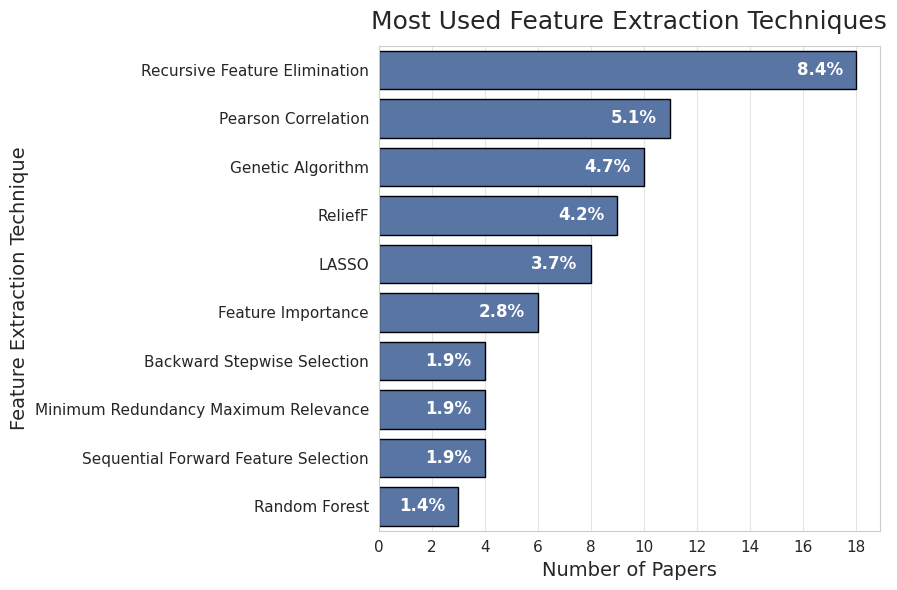

In [36]:
top10_techniques = technique_rank.head(10)
from matplotlib.ticker import MaxNLocator


# Seaborn style
sns.set_style("whitegrid")

# Figure size (single-column journal size)
plt.figure(figsize=(9, 6))

# Calculate percentages
percentages = top10_techniques['percentage']

# Bar plot
ax = sns.barplot(
    x=top10_techniques['count'],
    y=top10_techniques['technique'],
    color="#4C72B0",
    edgecolor="black"
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Labels and title
ax.set_title("Most Used Feature Extraction Techniques", fontsize=18, pad=12)
ax.set_xlabel("Number of Papers", fontsize=14)
ax.set_ylabel("Feature Extraction Technique", fontsize=14)

# Ticks
ax.tick_params(axis='both', labelsize=11)

# Add value and percentage labels on bars (closer to the end of the bars)
for i, (v, pct) in enumerate(zip(top10_techniques['count'], percentages)):
    ax.text(v - 0.5, i, f"{pct:.1f}%", va='center', ha='right', fontsize=12, fontweight='bold', color='white')

# Improve grid appearance
ax.grid(axis='x', color="#E5E5E5")
ax.grid(axis='y', visible=False)

# Tight layout for clean export
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, 'feat_sel_barplot.svg'), dpi=600)
